In [47]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from poker_embeddings.poker_utils.constants import RANKS_DICT
from poker_embeddings.poker_utils.model import (
    plot_train_loss)

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [49]:
ev_data = pd.read_csv("../data/processed/hand_ev_processed.csv")

In [50]:
ev_data

,hand,position,EV,players,card1,card2,suited,card1_rank_id,card2_rank_id,hand_type_id,position_id,players_id,pos_play
0,AAo,SB,2.72,10,A,A,o,12,12,2,0,8,SB10
1,KKo,SB,1.90,10,K,K,o,11,11,2,0,8,SB10
2,QQo,SB,1.18,10,Q,Q,o,10,10,2,0,8,SB10
3,JJo,SB,0.67,10,J,J,o,9,9,2,0,8,SB10
4,TTo,SB,0.38,10,T,T,o,8,8,2,0,8,SB10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9121,43s,D,-0.01,9,4,3,s,2,1,1,9,7,D9
9122,42o,D,-0.03,9,4,2,o,2,0,0,9,7,D9
9123,42s,D,-0.09,9,4,2,s,2,0,1,9,7,D9
9124,32o,D,-0.03,9,3,2,o,1,0,0,9,7,D9


In [51]:
class EVDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        card1_rank = row['card1_rank_id']
        card2_rank = row['card2_rank_id']
        hand_type = row['hand_type_id']
        position_id = row['position_id']
        players_id = row['players_id']
        ev = row['EV']
        return (
            torch.tensor(card1_rank, dtype=torch.long),
            torch.tensor(card2_rank, dtype=torch.long),
            torch.tensor(hand_type, dtype=torch.long),
            torch.tensor(position_id, dtype=torch.long),
            torch.tensor(players_id, dtype=torch.long),
            torch.tensor(ev, dtype=torch.float32)
            )


In [52]:
train_data, test_data = train_test_split(ev_data, test_size=0.2, random_state=29, stratify=ev_data[['pos_play']])
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

In [53]:
train_dataset = EVDataset(train_data)
test_dataset = EVDataset(test_data)
trainloader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

testloader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

In [54]:
class cVAE(nn.Module):
    def __init__(self, embedding_dim=2, hidden_dim=8, c_dim=5):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.ReLU(),
        )
        self.mean_fc = nn.Linear(hidden_dim, embedding_dim)
        self.logvar_fc = nn.Linear(hidden_dim, embedding_dim)

        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim+c_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, ev, c):
        h = self.encoder(ev)
        mean = self.mean_fc(h)
        logvar = self.logvar_fc(h)
        z = self.reparameterize(mean, logvar)
        z_c = torch.cat((z, c), dim=1)
        reconstructed_x = self.decoder(z_c)
        return reconstructed_x, mean, logvar




In [67]:
def loss_func(recon_x, x, mean, logvar, beta=0.8):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

    return recon_loss, kl_loss, recon_loss + kl_loss*beta

In [107]:
def create_condition_vector(card1_rank, card2_rank, hand_type, position_id, players_id):
    card1_onehot = F.one_hot(card1_rank, num_classes=13)
    card2_onehot = F.one_hot(card2_rank, num_classes=13)
    handtype_onehot = F.one_hot(hand_type, num_classes=3)
    position_onehot = F.one_hot(position_id, num_classes=10)
    players_id = players_id.unsqueeze(-1).float()
    c = torch.cat((
        card1_onehot,
        card2_onehot,
        handtype_onehot,
        position_onehot,
        players_id
    ), dim=1).float()
    return c

In [ ]:
def train_model(model, trainloader, testloader, optimizer, loss_func, device, epochs=10):
    train_losses = []
    test_losses = []
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for batch in trainloader:
            card1_rank, card2_rank, hand_type, position_id, players_id, ev = batch
            ev = ev.view(-1, 1).to(device)
            c = create_condition_vector(
                card1_rank,
                card2_rank,
                hand_type,
                position_id,
                players_id
            ).to(device)

            optimizer.zero_grad()
            reconstructed_x, mean, logvar = model(ev, c)
            recon_loss, kl_loss, loss = loss_func(reconstructed_x, ev, mean, logvar)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(trainloader)
        train_losses.append(avg_train_loss)
        model.eval()
        with torch.no_grad():
            total_test_loss = 0
            for batch in testloader:
                card1_rank, card2_rank, hand_type, position_id, players_id, ev = batch
                ev = ev.view(-1, 1).to(device)

                c = create_condition_vector(
                    card1_rank,
                    card2_rank,
                    hand_type,
                    position_id,
                    players_id
                    ).to(device)

                reconstructed_x, mean, logvar = model(ev, c)
                recon_loss, kl_loss, loss = loss_func(reconstructed_x, ev, mean, logvar)
                total_test_loss += loss.item()
            avg_test_loss = total_test_loss / len(testloader)
            test_losses.append(avg_test_loss)

        if epoch % (epochs//5) == 0 or epoch == epochs-1:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss}, Test Loss: {avg_test_loss}")

    return train_losses, test_losses



In [119]:
what = next(iter(trainloader))

In [101]:
model = cVAE(c_dim=40).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

In [102]:
train_losses, test_losses = train_model(model, trainloader, testloader, optimizer, loss_func, device, epochs=200)

Epoch 1/200, Train Loss: 7.249693843204042, Test Loss: 4.998356593066249
Epoch 41/200, Train Loss: 0.2132650323232393, Test Loss: 0.20544980158065929
Epoch 81/200, Train Loss: 0.20532738702452702, Test Loss: 0.19287179641682525
Epoch 121/200, Train Loss: 0.1999507021928287, Test Loss: 0.193560221971109
Epoch 161/200, Train Loss: 0.19891437570685927, Test Loss: 0.19353065472738495
Epoch 200/200, Train Loss: 0.19591885222446012, Test Loss: 0.1903950108279442


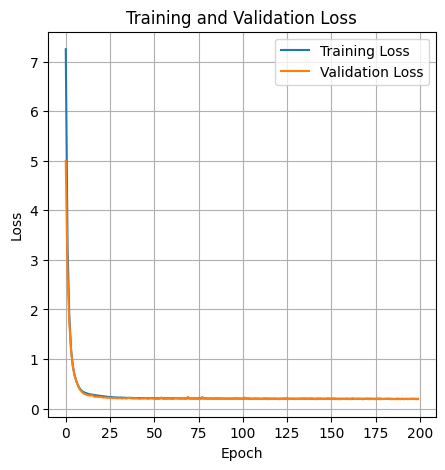

In [103]:
plot_train_loss(train_losses, test_losses)

In [128]:
def get_hand_info(hands: list):
    def get_hand_type(hand):
        if hand[0] == hand[1]:
            return 2 # pair
        elif hand[2] == 's':
            return 1 # suited
        else:
            return 0 # offsuit

    card_to_rank_id = {card: i for i, card in RANKS_DICT.items()}
    hand_info = []
    for hand in hands:
        card1, card2, suited = hand
        card1_rank_id = card_to_rank_id[card1]
        card2_rank_id = card_to_rank_id[card2]
        hand_type_id = get_hand_type(hand)
        hand_info.append((card1_rank_id, card2_rank_id, hand_type_id))
    return torch.tensor(hand_info)

In [138]:
get_hand_info(['AAo','KKo']).shape

torch.Size([2, 3])

In [142]:
def get_conditions(hands, position, players):
    positions = ['SB', 'BB', 'pos3', 'pos4', 'pos5', 'pos6', 'pos7', 'pos8', 'pos9','D']
    position_mapping = {pos: i for i, pos in enumerate(positions)}
    hand_info = get_hand_info(hands)
    card1_rank_id = hand_info[:, 0]
    card2_rank_id = hand_info[:, 1]
    hand_type_id = hand_info[:, 2]

    position_id = position_mapping[position]
    pos_ids = torch.tensor([position_id] * len(hands))
    play_ids = torch.tensor([players-2] * len(hands))
    return card1_rank_id, card2_rank_id, hand_type_id, pos_ids, play_ids


In [145]:
def sample_embeddings(model, hands, position, players):
    card1_rank, card2_rank, hand_type, position_ids, play_ids = get_conditions(hands, position, players)
    c = create_condition_vector(
        card1_rank,
        card2_rank,
        hand_type,
        position_ids,
        play_ids)
    sample = torch.randn(len(hands), model.mean_fc.out_features)
    data = torch.cat((sample, c), dim=1)
    model.to("cpu")
    model.eval()
    with torch.no_grad():
        gen_data = model.decoder(data)
    return gen_data.numpy()

In [147]:
def gen_ev_row(row):
    hand = [row['hand']]
    position = row['position']
    players = row['players']
    return sample_embeddings(model, hand, position, players)[0][0].item()


In [148]:
ev_data['vae_pred_ev'] = ev_data.apply(gen_ev_row, axis=1)

In [149]:
ev_data

,hand,position,EV,players,card1,card2,suited,card1_rank_id,card2_rank_id,hand_type_id,position_id,players_id,pos_play,vae_pred_ev
0,AAo,SB,2.72,10,A,A,o,12,12,2,0,8,SB10,2.705485
1,KKo,SB,1.90,10,K,K,o,11,11,2,0,8,SB10,1.665006
2,QQo,SB,1.18,10,Q,Q,o,10,10,2,0,8,SB10,1.124963
3,JJo,SB,0.67,10,J,J,o,9,9,2,0,8,SB10,0.763332
4,TTo,SB,0.38,10,T,T,o,8,8,2,0,8,SB10,0.435454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9121,43s,D,-0.01,9,4,3,s,2,1,1,9,7,D9,-0.073412
9122,42o,D,-0.03,9,4,2,o,2,0,0,9,7,D9,-0.027609
9123,42s,D,-0.09,9,4,2,s,2,0,1,9,7,D9,-0.074035
9124,32o,D,-0.03,9,3,2,o,1,0,0,9,7,D9,-0.057414


In [150]:
ev_data[['hand','EV','vae_pred_ev']].sort_values(by='EV', ascending=False)

,hand,EV,vae_pred_ev
1521,AAo,2.96,2.782586
1352,AAo,2.89,2.830712
8957,AAo,2.81,2.707887
169,AAo,2.81,2.686925
1014,AAo,2.79,2.715873
...,...,...,...
7899,92o,-0.42,-0.344575
290,94o,-0.42,-0.341669
280,T2o,-0.42,-0.356693
262,J3o,-0.42,-0.363106


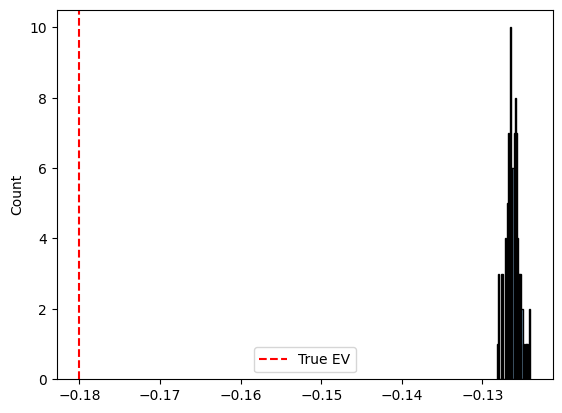

In [155]:
num_samples = 100
hand = ['72s']
position = 'pos3'
players = 6
embeddings = sample_embeddings(model, hand*num_samples, position, players)

sns.histplot(embeddings, bins=30)
true_ev = ev_data[(ev_data.hand == hand[0]) & (ev_data.position == position) & (ev_data.players == players)]['EV'].iloc[0]
plt.axvline(x=true_ev, color='red', linestyle='--', label='True EV')
plt.legend()
plt.show()